# Sentiment Classification Project

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import custom_dataloader
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import importlib
import embeddings
import models
from sklearn.metrics import confusion_matrix


# Load data

In [2]:
training_data = pd.read_csv('data/training.csv',index_col = 0)

In [3]:
# Encode the Labels (either as 0,1,2 for classification or -1,0,1 for regression)
label_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
# label_mapping = {'negative': 1, 'neutral': 0, 'positive': 2}
training_data['label_encoded'] = training_data['label'].map(label_mapping)

In [4]:
# training_data


# Build Validation Set
We use 90% of the reviews for training, and the remaining 10% for validation

In [5]:

sentences = training_data['sentence']
labels = training_data['label_encoded']

In [6]:
# Fix Random Seed for Reproducibility
random_seed = 42
train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences,labels, test_size=0.1, stratify=labels, random_state=random_seed)
train_sentences, val_sentences = list(train_sentences), list(val_sentences)
train_labels, val_labels = np.array(train_labels), np.array(val_labels)

In [7]:


# BALANCE_TRAINING = True

# Combine sentences and labels for easy manipulation
train_data = list(zip(train_sentences, train_labels))

# Separate by class
class_minus1 = [x for x in train_data if x[1] == -1]
class_0 = [x for x in train_data if x[1] == 0]
class_1 = [x for x in train_data if x[1] == 1]

# Find the smallest class size
min_size = min(len(class_minus1), len(class_0), len(class_1))

# Undersample all classes to match the smallest class
class_minus1_bal = resample(class_minus1, replace=False, n_samples=min_size, random_state=random_seed)
class_0_bal = resample(class_0, replace=False, n_samples=min_size, random_state=random_seed)
class_1_bal = resample(class_1, replace=False, n_samples=min_size, random_state=random_seed)

# Combine and shuffle
balanced_train_data = class_minus1_bal + class_0_bal + class_1_bal
np.random.shuffle(balanced_train_data)

# Split back into sentences and labels
train_sentences_bal, train_labels_bal = zip(*balanced_train_data)
train_sentences_bal, train_labels_bal = list(train_sentences_bal), np.array(train_labels_bal)

# Bag-of-words + Logistic Regression baseline

In [8]:
importlib.reload(embeddings) # This is so when I make changes in embeddings it will reload the changes instead of caching the old file.

# ****** change the following to access different embeddings

# embedding_model = embeddings.BOWEmbedding(ngram_range=(1, 2), max_features=10000, stop_words=None, min_df=1, max_df=1.0)  #baseline
# embedding_model = embeddings.BOWEmbedding(ngram_range=(1, 2), max_features=10000, stop_words='english', min_df=10, max_df=0.9)
# embedding_model = embeddings.TFIDFEmbedding(ngram_range=(1, 2), max_features=10000, stop_words=None, min_df=1, max_df=1.0)
# embedding_model = embeddings.BertPreTrained('bert-base-uncased') #bert-based-uncased model mean pooled
# embedding_model = embeddings.BertPreTrainedClassifier('textattack/bert-base-uncased-yelp-polarity') #pre-trained bert yelp classifier model. Should have two classes (positive and negative sentiment)
# embedding_model = embeddings.BertTokenEmbedder('textattack/bert-base-uncased-yelp-polarity') #pre-trained bert yelp classifier model tokenizer.
# embedding_model = embeddings.BertTokenEmbedder('arpitk/product-review-sentiment-analyzer') #pre-trained bert product review sentiment classifier
# embedding_model = embeddings.BertTokenEmbedder('./models_pretrained/distilbert_product_855_04-21') # my fine-tuned model
# embedding_model = embeddings.BertTokenEmbedder('distilbert/distilbert-base-cased') #pre-trained bert base cased
embedding_model = embeddings.BertTokenEmbedder('bert-base-uncased') #pre-trained bert base uncased
# embedding_model = embeddings.BertTokenEmbedder('answerdotai/ModernBERT-base') #pre-trained modern bert base uncased
# embedding_model = embeddings.BertTokenEmbedder('FacebookAI/roberta-base') #pre-trained roberta base




# embedding_model = embeddings.Bert_variable_length() # This isn't working great for me
# embedding_model = embeddings.Word2VecEmbedding2("GoogleNews-vectors-negative300.bin", binary=True)


# print(type(train_sentences_bal))

n_samples = -1# set to -1 to get all samples
n_val_samples = int(n_samples/10) if n_samples != -1 else -1
X_train = embedding_model.fit_transform(train_sentences[:n_samples])#For quick testing with less data
X_val = embedding_model.transform(val_sentences[:n_val_samples])

Y_train = train_labels[:n_samples]
Y_val = val_labels[:n_val_samples]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing batches: 100%|██████████| 320/320 [00:01<00:00, 163.10it/s]


In [9]:
# print(X_train[1])
# print(X_train.shape)
# X_clipped = X_train[:,1:]
# print(X_clipped.shape)
# print(confusion_matrix(Y_train,np.argmax(X_clipped,axis=1)*-2+1, labels=[-1, 0, 1]))

In [10]:
# number_examples = 5
# label_map = {-1: 'negative', 0: 'neutral', 1: 'positive'}
#
# misclassified = [
#     (label_map[true], label_map[pred], text)
#     for true, pred, text in zip(Y_val, np.argmax(X_train,axis=1)*2-1, val_sentences)
#     if true != pred and true!=0 and pred !=0
# ]
#
# import random
# for true, pred, text in random.sample(misclassified, number_examples):
#     print(f"True: {true}, Pred: {pred} → {text}")

In [11]:
# print(type(train_sentences_bal[1]))
# print(type(train_sentences_bal))
# print(type(train_sentences))
# print(type(val_labels))
# print(type(val_labels[1]))
# print(type(X_train))
# print(type(X_val))
# print(len(X_train[0]))
# print(len(X_val[0]))
# print(type(Y_train))
# print(type(Y_val))

In [12]:
# print(X_train[0])

In [9]:
importlib.reload(custom_dataloader)

#Initialize Dataloader If Necessary
train_sampler = custom_dataloader.DynamicUnderSampler(Y_train, random_state=42)
pre_compute = True
if embedding_model.is_variable_length:
    dataset_train = custom_dataloader.EmbeddingDataset(X_train, Y_train)
    dataset_val = custom_dataloader.EmbeddingDataset(X_val, Y_val)
    # print(len(dataset_train))
    train_loader = DataLoader(
        dataset_train,
        sampler=train_sampler,
        batch_size=8,
        collate_fn=custom_dataloader.collate_fn,
    )
    train_loader_pred = DataLoader(
        dataset_train,
        batch_size=64,
        collate_fn=custom_dataloader.collate_fn,
    )
    train_loader_pred_shuf = DataLoader(
        dataset_train,
        batch_size=16,
        shuffle=True,
        collate_fn=custom_dataloader.collate_fn,
    )
    val_loader = DataLoader(
        dataset_val,
        batch_size=64,
        collate_fn=custom_dataloader.collate_fn
    )

    if pre_compute:
        emb_loader = embedding_model.precompute_embeddings(train_loader_pred)
        emb_val_loader = embedding_model.precompute_embeddings(val_loader, val=True)

else:
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(Y_val, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor),sampler=train_sampler, batch_size=32)
    train_loader_pred = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)

In [14]:

# X_train
# print(X_val.shape)
# print(Y_val.shape)
# print(Y_train)
# for batch in train_loader:
#     print(batch[0][0][0])
#     print(batch[0][0][1])
#     break
    # print(batch['label'])
    # break

Now we train a logistic regression classifier...

In [20]:
importlib.reload(custom_dataloader)
importlib.reload(models)
# print(torch.cuda.memory_summary())# needed so it doesn't cache the functions
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
# print(torch.cuda.memory_summary())
# print(X_train.shape)

# ******** Change this to change the model
# model = models.Logistic_Regression_Baseline() 
# model = models.LinearMLP(input_dim = X_val.shape[1])
# model = models.NonLinearMLP(input_dim = X_val.shape[1])
# model = models.DropoutMLP(input_dim = 768, lr = 0.00005, hidden_dim1= 256, hidden_dim2 = 64, dropout_prob = 0.2, ce_weight = 0.1)
# model = models.BertPreTrainedClassifier('textattack/bert-base-uncased-yelp-polarity', lr = 2e-05, frozen = False) #pre-trained bert classifier
# model = models.BertPreTrainedClassifier('arpitk/product-review-sentiment-analyzer', lr = 2e-05, frozen = False, class_order = [0,2,1]) #pre-trained distilbert product review classifier
# model = models.BertPreTrainedClassifier('distilbert/distilbert-base-cased', lr = 5e-05, frozen = True, class_order = [0,1,2], dropout = 0.4, ce_weight = 0.1, temperature = 0.5, custom_ll = True, pt_lr = 5e-06) #pre-trained bert cased no fine tune
model = models.BertPreTrainedClassifier('bert-base-uncased', lr = 5e-05, frozen = True, class_order = [0,1,2], dropout = 0.4, ce_weight = 1, temperature = 0.5, custom_ll = True, pt_lr_top = 5e-05, pt_lr_mid = 3e-05, pt_lr_bot = 2e-05) #pre-trained bert base uncased no fine tune
# model = models.BertPreTrainedClassifier('answerdotai/ModernBERT-base', lr = 5e-05, frozen = True, class_order = [0,1,2], dropout = 0.4, ce_weight = 0.1, temperature = 0.5, custom_ll = True, pt_lr_top = 5e-05, pt_lr_mid = 5e-06, pt_lr_bot = 5e-07)#pre-trained modern bert base no fine tune
# model = models.BertPreTrainedClassifier('FacebookAI/roberta-base', lr = 5e-05, frozen = True, class_order = [0,1,2], dropout = 0.4, ce_weight = 0.1, temperature = 0.5, custom_ll = True, pt_lr_top = 5e-05, pt_lr_mid = 5e-06, pt_lr_bot = 5e-07)#pre-trained roberta base no fine tune
# model = models.BertPreTrainedClassifier('./models_pretrained/distilbert_product_855_04-21', lr = 1e-05, frozen = False, class_order = [0,2,1], dropout = 0.1, ce_weight = 0.1, temperature = 0.5) #my fine-tuned model
# model = models.LSTMClassifier(input_dim = X_val[0].shape[1], lr=0.00005, dropout=0.2, hidden_dim=256, num_layers=2)



# if model.is_variable_length:
#     train_data = [{'text': text, 'label': label} for text, label in zip(train_sentences, train_labels)]
#     val_data = [{'text': text, 'label': label} for text, label in zip(val_sentences, val_labels)]
#     train_loader, val_loader = model.create_dataloaders(train_data, val_data)



Training BertPreTrainedClassifier on cuda


Training:   0%|          | 0/7395 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/160 [00:00<?, ?batch/s]

Epoch 1/4: 
Train Loss: 1.3049, Acc: 0.5673 Train Neg Acc: 0.6988, Nut Acc: 0.4613, Pos Acc: 0.7180
 Val Loss: 1.1869, Acc: 0.6360 Val Neg Acc: 0.4474, Nut Acc: 0.7889, Pos Acc: 0.7393


Training:   0%|          | 0/7395 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/160 [00:00<?, ?batch/s]

Epoch 2/4: 
Train Loss: 1.1668, Acc: 0.6653 Train Neg Acc: 0.7539, Nut Acc: 0.5517, Pos Acc: 0.7681
 Val Loss: 1.0575, Acc: 0.7197 Val Neg Acc: 0.6022, Nut Acc: 0.7819, Pos Acc: 0.7326


Training:   0%|          | 0/7395 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/160 [00:00<?, ?batch/s]

Epoch 3/4: 
Train Loss: 1.0318, Acc: 0.7488 Train Neg Acc: 0.8091, Nut Acc: 0.6417, Pos Acc: 0.8391
 Val Loss: 1.1278, Acc: 0.6638 Val Neg Acc: 0.5654, Nut Acc: 0.8826, Pos Acc: 0.5941


Training:   0%|          | 0/7395 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/160 [00:00<?, ?batch/s]

Epoch 4/4: 
Train Loss: 0.9062, Acc: 0.8033 Train Neg Acc: 0.8567, Nut Acc: 0.7051, Pos Acc: 0.8732
 Val Loss: 1.2367, Acc: 0.7307 Val Neg Acc: 0.5936, Nut Acc: 0.8152, Pos Acc: 0.7471


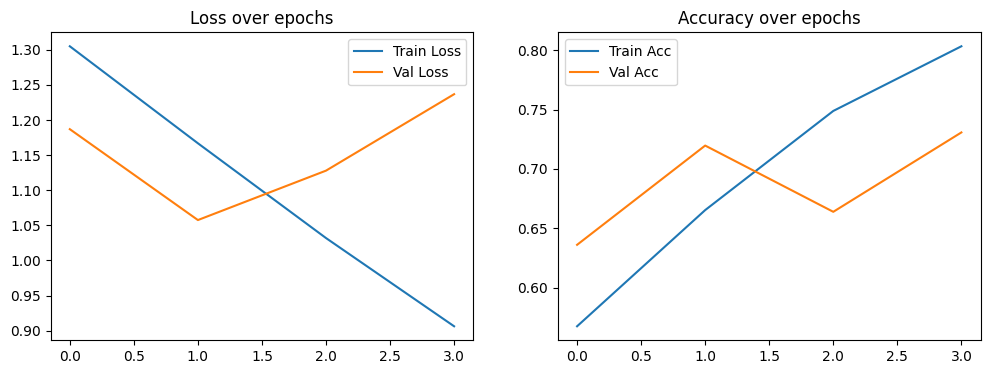

In [23]:
#If model requires dataloader, Load data into dataloader:
load_from_path = False
if load_from_path:
    model_path = "models/distilbert_product_855_04-21.pt"
    print("Loading model from {}".format(model_path))
    model.load_state_dict(torch.load(model_path))

# print(X_train.shape)
if model.use_dataloader:
    if model.frozen:
        model.fit(emb_loader,emb_val_loader,epochs=6)
    else:
        model.fit(train_loader,val_loader,epochs=4) #train_loader_pred_shuf has no class balancing
    # model.fit(train_loader,epochs=10)
else:
    model.fit(X_train,Y_train)

In [22]:
#after warming up classification head, allow fine-tuning of bert:
#Everytime you run this cell, it will toggle freezing the transformer and unfreezing it.

layers_to_freeze = 1 #set how many layers from the bottom you want to leave frozen when fine-tuning. 0 to unfreeze everything.

for attr in ("encoder", "transformer", "layers"):  # This is to set the "model layer" correctly for different model architectures.
    backbone = getattr(model.model, attr, None)
    if backbone is not None:
        if attr in ("encoder","transformer"):
            backbone = backbone.layer
        break

if model.frozen:
    print("model unfrozen")
    model.frozen = False
    for param in model.model.parameters(): #unfreeze all params
        param.requires_grad = True
    for param in model.model.embeddings.parameters(): #re-freeze the embedding layers (maybe we don't want this? Haven't tried yet)
        param.requires_grad = False
    for i in range(layers_to_freeze):  # freezes bottom most layers
        for param in backbone[i].parameters():
            param.requires_grad = False
else: #Toggle frozen again
    print("model frozen")
    model.frozen = True
    for param in model.model.parameters():
        param.requires_grad = False



model unfrozen


In [18]:
# #change ce_weight
# model.ce_weight = 0
# model.criterion = model._configure_criterion()

In [24]:
if model.use_dataloader:
    # Y_train_pred = model.predict(train_loader_pred)
    # print(type(Y_train_pred))
    # Predict on Validation Set
    Y_val_pred = model.predict(val_loader)

else: 
    # Y_train_pred = model.predict(X_train)
    # Predict on Validation Set
    Y_val_pred = model.predict(X_val)

Predicting:   0%|          | 0/160 [00:00<?, ?batch/s]

In [25]:
from sklearn.metrics import mean_absolute_error
# Score on Training Set
# mae_train = mean_absolute_error(Y_train, Y_train_pred)
# L_score_train = 0.5 * (2 - mae_train)
# Score on Validation Set
mae_val = mean_absolute_error(Y_val, Y_val_pred)
L_score_val = 0.5 * (2 - mae_val)

In [26]:
from sklearn.metrics import confusion_matrix
# print(f'Evaluation Score (training set): {L_score_train:.05f}')
print(f'Evaluation Score (validation set): {L_score_val:.05f}')


# conf_matrix = confusion_matrix(Y_train,Y_train_pred, labels=[-1, 0, 1])
# print(conf_matrix)
conf_matrix = confusion_matrix(Y_val,Y_val_pred, labels=[-1, 0, 1])
print(conf_matrix)

Evaluation Score (validation set): 0.84092
[[1760  239  191]
 [ 897 3446  572]
 [ 308  542 2254]]


In [49]:

model_path = "roberta_875_04-27"
torch.save(model.state_dict(), "models/" + model_path + ".pt")
model.model.save_pretrained("models_pretrained/" + model_path)
model.model.config.save_pretrained("configs/" + model_path)
model.tokenizer.save_pretrained("models_pretrained/" + model_path)


('models_pretrained/roberta_875_04-27\\tokenizer_config.json',
 'models_pretrained/roberta_875_04-27\\special_tokens_map.json',
 'models_pretrained/roberta_875_04-27\\vocab.json',
 'models_pretrained/roberta_875_04-27\\merges.txt',
 'models_pretrained/roberta_875_04-27\\added_tokens.json',
 'models_pretrained/roberta_875_04-27\\tokenizer.json')

In [34]:
# Ensemble:
# from transformers import AutoModelForSequenceClassification
#
# model_paths = ["models/bert_base_uncased_yelp_844_04-20.pt",
#                "models/distilbert_cased_833_04-21.pt",
#                "models/distilbert_cased_837_04-21.pt",
#                "models/distilbert_cased_845_04-21.pt",
#                "models/distilbert_product_849_04-20.pt",
#                "models/distilbert_product_833_04-21.pt",]
# configs = ["textattack/bert-base-uncased-yelp-polarity",
#            "distilbert/distilbert-base-cased",
#            "distilbert/distilbert-base-cased",
#            "distilbert/distilbert-base-cased",
#            "arpitk/product-review-sentiment-analyzer",
#            "arpitk/product-review-sentiment-analyzer"]
#
# for i in range(len(model_paths)):
#     model_p = model_paths[i]
#     model_c = configs[i]
#     print("Loading model from {}".format(model_p))
#     model_ensemble = AutoModelForSequenceClassification.from_config(model_c)
#     model.load_state_dict(torch.load(model_p))




# Test Data

In [50]:
test_data = pd.read_csv('data/test.csv',index_col = 0)

In [22]:
# test_data

In [51]:
X_test = embedding_model.transform(test_data['sentence'])



# X_Custom_test = embedding_model.transform(np.array(["if anyone wants to have the most delicious dinner, go somewhere else"]))

Processing batches: 100%|██████████| 374/374 [00:02<00:00, 158.89it/s]


In [24]:
# test_data['sentence']

In [52]:
# print(Y_train.shape)
# print(X_test.shape)
Y_test_fake_labels = np.ones(X_test.shape[0]) # This is just for the dataloader, too lazy to make it work without labels.
# print(Y_test.shape)
# Y_test = np.ones_like(X_test)

if embedding_model.is_variable_length:
    dataset_test = custom_dataloader.EmbeddingDataset(X_test, Y_test_fake_labels)
    # print(len(dataset_train))
    test_loader = DataLoader(
        dataset_test,
        batch_size=64,
        collate_fn=custom_dataloader.collate_fn,
    )
else:
    if hasattr(X_test, 'toarray'):
        X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
    else:
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    test_loader = DataLoader(TensorDataset(X_test_tensor, X_test_tensor), batch_size=32)

# print(X_test[0].shape)

if model.use_dataloader:
    y_test = model.predict(test_loader)
else: 
    y_test = model.predict(X_test)


# print(test_data.index)

# y_test = model.predict(X_Custom_test)
# print(y_test)

Predicting:   0%|          | 0/187 [00:00<?, ?batch/s]

In [53]:
# Save predictions in the correct format
# y_test_adjusted = model._adjust_labels(y_test)
y_labels = pd.Series(y_test).map({-1: 'negative', 0: 'neutral', 1: 'positive'})
submission = pd.DataFrame({'id': test_data.index, 'label': y_labels})
submission.to_csv('test_predictions.csv', index=False) # Update filename and path as needed
print("Test predictions saved to 'test_predictions.csv'")

Test predictions saved to 'test_predictions.csv'


# Model Interpretation

In [29]:
# # Top N most Important Words & Word Pairs per Output Class (Pos, Neutral, Negative)
# feature_names = embedding_model.get_feature_names_out() # get names of all tokens from vectorizer
# coefs = model.coef()  # Weights per Feature for each Output Class; Shape: (Num_Output_Classes, Num_Features)
#
# # Get Top_n Features by Weight for each Class
# def get_top_features(class_index, top_n=10):
#     class_coef = coefs[class_index]
#     top_indices = np.argsort(class_coef)[-top_n:]
#     return [feature_names[i] for i in reversed(top_indices)]
#
# print("Top words & bigrams for negative (-1):", get_top_features(0))
# print("Top words & bigrams for positive (1):", get_top_features(2))
# print("Top words & bigrams for neutral (0):", get_top_features(1))

In [27]:
# # Confusion Matrix - Negative, Neutral, Positive
# from sklearn.metrics import confusion_matrix
#
# conf_matrix = confusion_matrix(Y_val,Y_val_pred, labels=[-1, 0, 1])
# print(conf_matrix)

In [42]:
# Examples of Misclassified Sentences
number_examples = 5
label_map = {-1: 'negative', 0: 'neutral', 1: 'positive'}

misclassified = [
    (label_map[true.item()], label_map[pred.item()], text)
    for true, pred, text in zip(Y_val, Y_val_pred, val_sentences)
    if true != pred
]

import random
for true, pred, text in random.sample(misclassified, number_examples):
    print(f"True: {true}, Pred: {pred} → {text}")

True: positive, Pred: negative → The rice portions was not a lot which I love and so did the people I came with.
True: neutral, Pred: positive → The film will appeal to Discovery Channel fans and will surely widen the perspective of those of us who see the continent through rose-colored glasses .
True: negative, Pred: neutral → The food is all small plates.
True: neutral, Pred: positive → This is not Chabrol 's best , but even his lesser works outshine the best some directors can offer .
True: negative, Pred: positive → MOLDY food served at a respected restaurant.
